In [16]:
## April 10 2017
## Judy Fan (jefan@)
## DESIGN ## ## ## ## 
## There are four objects (bed, bench, chair, table). Participants viewed each object 20 times per run.
## Runs 1 & 2 -- reserved to conduct searchlight
## Runs 3 & 4 -- pretest phase 
## Four training runs involving practice drawing two of the trained objects. 
## Runs 5 & 6 -- posttest phase
## GOAL ## ## ## ## 
## Compare similarity between Trained object representations before and after training (vs. Control) in several
## anatomically-defined ROIs. To do this, define `representation' as cope maps generated 
## upon fitting GLM to each object for each run. Build object x voxel matrix (4xK) for each run, vertically concatenate
## the two runs in each phase, and compute correlation matrix. Consider M = off-diagonal 4x4 block [:4,4:8].
## Make sure the rows are sorted such that the first two are the Trained, and the last two are the Control objects.
## Now take the the top-left 2x2 matrix within M and let's call it M-trained. The bottom-right 2x2 = M-control.
## The diagonal elements of M-trained (A,D depicted below) reflect the representational similarity for the *same* object between runs.
## The off diagonal elements of M-trained (B,C) reflect the similarity between different objects across runs. 
## [_A_|_B_]
## [_C_|_D_]
## Mean of (B,C) - Mean(A,D) = Representational distance between objects in this phase. 
## Do the above for the pretest, then for the posttest, and compare.

## NOTE: On the 'sketchloop' machine, data are found in sketchloop02 directory at the same level as this 'neurosketch' 
## analysis directory, and are organized by subject. All the paths here are defined for the file organization on this 
## computer, so this code won't run as-is 

import warnings
warnings.filterwarnings('ignore')

In [17]:
import numpy as np
import glob
import os
import scipy.stats as stats
from sklearn import metrics
import matplotlib
matplotlib.use("Pdf")
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
import seaborn as sns

import brainiak
import nilearn
import nibabel
import json
from sklearn.metrics.pairwise import pairwise_distances as pd
from sklearn import svm
import sklearn
import analysis_helpers as helpers
import _pickle as cPickle

from nilearn import image
from nilearn import plotting

## Setup

In [18]:
# load in experimental design pickle file

with open('morph_drawing_training_design.pkl', 'rb') as f:
    mdtd = cPickle.load(f, encoding='latin1') 

In [19]:
## cope numbering legend
## cope1 = 'bed'
## cope2 = 'bench'
## cope3 = 'chair'
## cope4 = 'table'

cope2obj = {'cope1':'bed','cope2':'bench', 'cope3':'chair','cope4':'table'}
obj2cope = {'bed':1,'bench':2, 'chair':3,'table':4}

In [20]:
# behavioral data from database
with open('versionNums.json') as json_data:
    coll = json.load(json_data)

In [21]:
## get list of subject directories

roi_dir = '/home/jgunn/neurosketch/surferROIs/'
cope_dir = '/home/jgunn/neurosketch/hires_copes'
contents_dir = os.listdir(roi_dir)

sub_dirs = []
for i in contents_dir:
    try:
        if i.split('_')[1]=='neurosketch':
            sub_dirs.append(i)
    except:
        pass

sub_dirs = sorted(sub_dirs)

# issue with 1207161
sub_dirs = [s for s in sub_dirs if s != '1207161_neurosketch']

print(sub_dirs)
print(str(len(sub_dirs)) + ' subjects')

['0110171_neurosketch', '0110172_neurosketch', '0111171_neurosketch', '0112171_neurosketch', '0112172_neurosketch', '0112173_neurosketch', '0113171_neurosketch', '0115174_neurosketch', '0117171_neurosketch', '0118171_neurosketch', '0118172_neurosketch', '0119171_neurosketch', '0119172_neurosketch', '0119173_neurosketch', '0119174_neurosketch', '0120171_neurosketch', '0120172_neurosketch', '0120173_neurosketch', '0123171_neurosketch', '0123173_neurosketch', '0124171_neurosketch', '0125171_neurosketch', '0125172_neurosketch', '1121161_neurosketch', '1130161_neurosketch', '1201161_neurosketch', '1202161_neurosketch', '1203161_neurosketch', '1206161_neurosketch', '1206162_neurosketch', '1206163_neurosketch', '1207162_neurosketch']
32 subjects


In [23]:
## Analysis helper functions (see and update: analysis_helpers.py)

def get_object_index(morphline,morphnum):
    furniture_axes = ['bedChair', 'bedTable', 'benchBed', 'chairBench', 'chairTable', 'tableBench']
    car_axes = ['limoToSUV','limoToSedan','limoToSmart','smartToSedan','suvToSedan','suvToSmart']  
    furniture_items = ['bed','bench','chair','table']
    car_items = ['limo','sedan','smartcar','SUV']               
    endpoints = mdr_helpers.getEndpoints(morphline)
    morphnum = float(morphnum)
    whichEndpoint = int(np.round(morphnum/100))
    thing = endpoints[whichEndpoint]
    if morphline in furniture_axes:
        return furniture_items.index(thing)+1
    elif morphline in car_axes:
        return car_items.index(thing)+1    
    
def getEndpoints(morphline):    
    if morphline=='sedanMinivan':
        return ['sedan','minivan']
    elif morphline=='minivanSportscar':
        return ['minivan','sportscar']
    elif morphline=='sportscarSUV':
        return ['sportscar','SUV']
    elif morphline=='SUVMinivan':
        return ['SUV','minivan']
    elif morphline=='sportscarSedan':
        return ['sportscar','sedan']
    elif morphline=='sedanSUV':
        return ['sedan','SUV']
    elif morphline=='bedChair':
        return ['bed','chair']
    elif morphline=='bedTable':
        return ['bed','table']
    elif morphline=='benchBed':
        return ['bench','bed']
    elif morphline=='chairBench':
        return ['chair','bench']
    elif morphline=='chairTable':
        return ['chair','table']
    elif morphline=='tableBench':
        return ['table','bench']
    elif morphline=='limoToSUV':
        return ['limo','SUV']    
    elif morphline=='limoToSedan':
        return ['sedan','limo']  
    elif morphline=='limoToSmart':
        return ['limo','smartcar']  
    elif morphline=='smartToSedan':
        return ['smartcar','sedan']    
    elif morphline=='suvToSedan':
        return ['SUV','sedan']  
    elif morphline=='suvToSmart':
        return ['SUV','smartcar']  
    else:
        return ['A','B']          

    
def triple_sum(X):
    return sum(sum(sum(X)))

def get_mask_array(mask_path):
    mask_img = image.load_img(mask_path)
    mask_data = mask_img.get_data()
    num_brain_voxels = sum(sum(sum(mask_data==1)))
    return mask_data, num_brain_voxels
    
def load_roi_mask(subj,run_num,roi):
    if ['V1', 'V2'].count(roi) > 0:
        mask_path = roi_dir + subj + '/' + roi + '.nii.gz'
    else:
        mask_path = roi_dir + subj + '/' + roi + '_FS.nii.gz'
    mask_data, nv = get_mask_array(mask_path)
    return mask_data

def load_roi_mask_combined(subj,run_num,roi):
    return load_roi_mask(subj,run_num,roi)
    return mask_data

def normalize(X):
    mn = X.mean(0)
    sd = X.std(0)
    X = X - mn
    X = X / np.maximum(sd, 1e-5)
    return X

def load_single_run_weights(subj,run_num,cope_num):
    nifti_path = cope_dir + '/' + subj[:7] + '_run' + str(run_num) + '_cope' + str(cope_num) + '_hires.nii.gz'
    fmri_img = image.load_img(nifti_path)
    fmri_data = fmri_img.get_data()
    return fmri_data

def apply_mask(data,mask):
    return data[mask==1]

def load_data_and_apply_mask(subj,run_num,roi,cope_num):
    if roi=='ventemp':
        mask_data_1 = load_roi_mask_combined(s,1,'fusiform')
        mask_data_2 = load_roi_mask_combined(s,1,'IT')
        mask_data_3 = load_roi_mask_combined(s,1,'parahippo')
#         mask_data_4 = load_roi_mask_combined(s,1,'LOC')
        mask = mask_data_1 + mask_data_2 + mask_data_3 # + mask_data_4
    elif roi=='occipital':
        mask_data_1 = load_roi_mask_combined(s,1,'V1')
        mask_data_2 = load_roi_mask_combined(s,1,'LOC')                
        mask = mask_data_1 + mask_data_2
    else:
        mask = load_roi_mask_combined(subj,run_num,roi)
    vol = load_single_run_weights(subj,run_num,cope_num)
    vec = apply_mask(vol,mask)
    return vec

def extract_obj_by_voxel_run_mat(this_sub,run_num, roi):
    cope1 = load_data_and_apply_mask(this_sub,run_num,roi,1)
    cope2 = load_data_and_apply_mask(this_sub,run_num,roi,2)
    cope3 = load_data_and_apply_mask(this_sub,run_num,roi,3)
    cope4 = load_data_and_apply_mask(this_sub,run_num,roi,4)
    return np.vstack((cope1,cope2,cope3,cope4))

def plot_phase_RSM(this_sub,roi,phase):
    '''
    e.g., plot_phase_RSM(this_sub,'fusiform','pre')
    '''
    if phase=='pre':
        mat1 = extract_obj_by_voxel_run_mat(this_sub,3,roi)
        mat2 = extract_obj_by_voxel_run_mat(this_sub,4,roi)
    elif phase=='post':
        mat1 = extract_obj_by_voxel_run_mat(this_sub,5,roi)
        mat2 = extract_obj_by_voxel_run_mat(this_sub,6,roi)        
    stacked = np.vstack((mat1,mat2))
    plt.matshow(np.corrcoef(stacked))
    plt.colorbar()
    
def extract_condition_by_voxel_run_mat(this_sub,run_num, roi):
    versionNum = coll[this_sub]

    design = [i for i in mdtd if i['version'] == int(versionNum)] # find which axes belong to which condition
    trained = design[0]['trained']
    near = design[0]['near']
    far1 = design[0]['far1']
    far2 = design[0]['far2']

    Tep = getEndpoints(trained)
    Nep = getEndpoints(near)
    condorder = Tep + Nep

    slot1 = load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[0]])
    slot2 = load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[1]])
    slot3 = load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[2]])
    slot4 = load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[3]])
    return np.vstack((slot1,slot2,slot3,slot4))
    
def splice_condition_by_voxel_run_mats(this_sub, phase, diag, roi):
    versionNum = coll[this_sub]

    design = [i for i in mdtd if i['version'] == int(versionNum)] # find which axes belong to which condition
    trained = design[0]['trained']
    near = design[0]['near']
    far1 = design[0]['far1']
    far2 = design[0]['far2']

    Tep = getEndpoints(trained)
    Nep = getEndpoints(near)
    condorder = Tep + Nep

    if diag == 'on':
        if phase == 'first':
            slot1 = load_data_and_apply_mask(this_sub,3,roi,obj2cope[condorder[0]])
            slot2 = load_data_and_apply_mask(this_sub,5,roi,obj2cope[condorder[1]])
            slot3 = load_data_and_apply_mask(this_sub,3,roi,obj2cope[condorder[2]])
            slot4 = load_data_and_apply_mask(this_sub,5,roi,obj2cope[condorder[3]])
        elif phase == 'second':
            slot1 = load_data_and_apply_mask(this_sub,4,roi,obj2cope[condorder[0]])
            slot2 = load_data_and_apply_mask(this_sub,6,roi,obj2cope[condorder[1]])
            slot3 = load_data_and_apply_mask(this_sub,4,roi,obj2cope[condorder[2]])
            slot4 = load_data_and_apply_mask(this_sub,6,roi,obj2cope[condorder[3]])
    elif diag == 'off':
        if phase == 'first':
            slot1 = load_data_and_apply_mask(this_sub,5,roi,obj2cope[condorder[0]])
            slot2 = load_data_and_apply_mask(this_sub,3,roi,obj2cope[condorder[1]])
            slot3 = load_data_and_apply_mask(this_sub,5,roi,obj2cope[condorder[2]])
            slot4 = load_data_and_apply_mask(this_sub,3,roi,obj2cope[condorder[3]])
        elif phase == 'second':
            slot1 = load_data_and_apply_mask(this_sub,6,roi,obj2cope[condorder[0]])
            slot2 = load_data_and_apply_mask(this_sub,4,roi,obj2cope[condorder[1]])
            slot3 = load_data_and_apply_mask(this_sub,6,roi,obj2cope[condorder[2]])
            slot4 = load_data_and_apply_mask(this_sub,4,roi,obj2cope[condorder[3]])
    return np.vstack((slot1,slot2,slot3,slot4))
    
def remove_nans(array):
    return array[~np.isnan(array)]

def rmse(a):
    return np.sqrt(np.mean(map(np.square,a)))

def betwitdist(a,b,ab):
    return ab/np.sqrt(0.5*(a**2+b**2))

def norm_hist(data,bins):
    weights = np.ones_like(data)/float(len(data))
    plt.hist(data, bins=bins, weights=weights)
    
def compare_btw_wit_obj_similarity_across_runs(this_sub,phase,roi):
    if phase=='pre':
        mat1 = extract_obj_by_voxel_run_mat(this_sub,3,roi)
        mat2 = extract_obj_by_voxel_run_mat(this_sub,4,roi)
    elif phase=='post':
        mat1 = extract_obj_by_voxel_run_mat(this_sub,5,roi)
        mat2 = extract_obj_by_voxel_run_mat(this_sub,6,roi)        
    fAB = np.vstack((mat1,mat2)) # stack feature matrices
    DAB = sklearn.metrics.pairwise.pairwise_distances(fAB, metric='correlation') # square matrix, where off-diagblock is distances *between* fA and fB vectors
    offblock = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])]
    wit_obj = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])].diagonal()
    btw_obj = np.hstack((offblock[np.triu_indices(shape(offblock)[0],k=1)],offblock[np.tril_indices(shape(offblock)[0],k=-1)]))
    wit_mean = wit_obj.mean()
    btw_mean = btw_obj.mean()
    return wit_mean,btw_mean

def compare_btw_wit_cond_similarity_across_runs(this_sub,phase,roi):

    if phase=='pre':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,3,roi)
        mat2 = extract_condition_by_voxel_run_mat(this_sub,4,roi)
    elif phase=='post':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,5,roi)
        mat2 = extract_condition_by_voxel_run_mat(this_sub,6,roi)

    fAB = np.vstack((mat1,mat2)) # stack feature matrices
    DAB = sklearn.metrics.pairwise.pairwise_distances(fAB, metric='correlation') # square matrix, where off-diagblock is distances *between* fA and fB vectors
    offblock = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])]

    trained_witobj = offblock.diagonal()[:2]
    control_witobj = offblock.diagonal()[2:]
    trained_btwobj = np.array([offblock[:2,:2][0,1], offblock[:2,:2][1,0]])
    control_btwobj = np.array([offblock[2:,2:][0,1],offblock[2:,2:][1,0]])

    trawit_mean = trained_witobj.mean()
    conwit_mean = control_witobj.mean()
    trabtw_mean = trained_btwobj.mean()
    conbtw_mean = control_btwobj.mean()
    return trawit_mean,conwit_mean,trabtw_mean,conbtw_mean

def anchor_compare(this_sub, diagonal, roi):
    mat1 = splice_condition_by_voxel_run_mats(this_sub, 'first', diagonal, roi)
    mat2 = splice_condition_by_voxel_run_mats(this_sub, 'second', diagonal, roi)

    fAB = np.vstack((mat1,mat2)) # stack feature matrices
    DAB = sklearn.metrics.pairwise.pairwise_distances(fAB, metric='correlation') # square matrix, where off-diagblock is distances *between* fA and fB vectors
    offblock = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])]

    trained_witobj = offblock.diagonal()[:2]
    control_witobj = offblock.diagonal()[2:]
    trained_btwobj = np.array([offblock[:2,:2][0,1], offblock[:2,:2][1,0]])
    control_btwobj = np.array([offblock[2:,2:][0,1],offblock[2:,2:][1,0]])

    trawit_mean = trained_witobj.mean()
    conwit_mean = control_witobj.mean()
    trabtw_mean = trained_btwobj.mean()
    conbtw_mean = control_btwobj.mean()
    return trawit_mean,conwit_mean,trabtw_mean,conbtw_mean

## Similarity analysis

In [13]:
## DESIGN ## ## ## ## 
## There are four objects (bed, bench, chair, table). Participants viewed each object 20 times per run.
## Runs 1 & 2 -- reserved to conduct searchlight
## Runs 3 & 4 -- pretest phase 
## Four training runs involving practice drawing two of the trained objects. 
## Runs 5 & 6 -- posttest phase
## GOAL ## ## ## ## 
## Compare similarity between Trained object representations before and after training (vs. Control) in several
## anatomically-defined ROIs. To do this, define `representation' as cope maps generated 
## upon fitting GLM to each object for each run. Build object x voxel matrix (4xK) for each run, vertically concatenate
## the two runs in each phase, and compute correlation matrix. Consider M = off-diagonal 4x4 block [:4,4:8].
## Make sure the rows are sorted such that the first two are the Trained, and the last two are the Control objects.
## Now take the the top-left 2x2 matrix within M and let's call it M-trained. The bottom-right 2x2 = M-control.
## The diagonal elements of M-trained (A,D depicted below) reflect the representational similarity for the *same* object between runs.
## The off diagonal elements of M-trained (B,C) reflect the similarity between different objects across runs. 
## [_A_|_B_]
## [_C_|_D_]
## Mean of (B,C) - Mean(A,D) = Representational distance between objects in this phase. 
## Do the above for the pretest, then for the posttest, and compare.

In [14]:
## Example code block single subject and ROI (fusiform):
run_example = 1
if run_example:
    trawit_mean_pre,conwit_mean_pre,trabtw_mean_pre,conbtw_mean_pre = compare_btw_wit_cond_similarity_across_runs(this_sub,'pre','fusiform')
    trawit_mean_post,conwit_mean_post,trabtw_mean_post,conbtw_mean_post = compare_btw_wit_cond_similarity_across_runs(this_sub,'post','fusiform')

    tradiff_pre = trabtw_mean_pre - trawit_mean_pre
    condiff_pre = conbtw_mean_pre - conwit_mean_pre

    tradiff_post = trabtw_mean_post - trawit_mean_post
    condiff_post = conbtw_mean_post - conwit_mean_post

    print('Trained Btw-Wit Post-Pre: ' + str(tradiff_post-tradiff_pre))
    print('Control Btw-Wit Post-Pre: ' + str(condiff_post-condiff_pre))  

NameError: name 'compare_btw_wit_cond_similarity_across_runs' is not defined

In [25]:
### April 8 2017: Now compute for all subjects (N=33 at time of initial commit), and for 5 different anat-ROIs

Tradiffpre = []
Condiffpre = []
#Tradiffpost = []
#Condiffpost = []
Trained = []
Control = []

# ventemp = ventral temporal ROI = IT + parahippo + fusiform
# occipital = ventral temporal ROI = V1 + LOC
ROIs = ["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp"]
ROIs = ['V1','fusiform','IT','LOC','occitemp','parahippo','ventemp', 'occipital']

for roi in ROIs:
    print(roi)    
    _Tradiffpre = []
    _Condiffpre = []
    #_Tradiffpost = []
    #_Condiffpost = []
    _Trained = []
    _Control = []
        
    for s in sub_dirs:
        print(s)
        trawit_mean_pre, conwit_mean_pre, trabtw_mean_pre, conbtw_mean_pre = \
        compare_btw_wit_cond_similarity_across_runs(s,'pre',roi)
        trawit_mean_post, conwit_mean_post, trabtw_mean_post, conbtw_mean_post = \
        compare_btw_wit_cond_similarity_across_runs(s,'post',roi)
        
        trawit_mean_on, conwit_mean_on, trabtw_mean_on, conbtw_mean_on = \
        anchor_compare(s,'on',roi)
        trawit_mean_off, conwit_mean_off, trabtw_mean_off, conbtw_mean_off = \
        anchor_compare(s,'off',roi)
        
        _Tradiffpre.append(trabtw_mean_pre - trawit_mean_pre)
        _Condiffpre.append(conbtw_mean_pre - conwit_mean_pre)
    
        _Trained.append(np.mean([(trabtw_mean_on - trawit_mean_on), (trabtw_mean_off - trawit_mean_off)]) - (trabtw_mean_pre - trawit_mean_pre))
        _Control.append(np.mean([(conbtw_mean_on - conwit_mean_on), (conbtw_mean_off - conwit_mean_off)]) - (conbtw_mean_pre - conwit_mean_pre))
        
    _Tradiffpre,_Condiffpre, _Trained, _Control = map(np.array, \
                                                               [_Tradiffpre,_Condiffpre,_Trained, _Control])
        
    if len(Tradiffpre)==0:
        Tradiffpre = _Tradiffpre
        Condiffpre = _Condiffpre
        Trained = _Trained
        Control = _Control
    else:
        Tradiffpre = np.vstack((Tradiffpre,_Tradiffpre))
        Condiffpre = np.vstack((Condiffpre,_Condiffpre))
        Trained = np.vstack((Trained,_Trained))
        Control = np.vstack((Control,_Control))

V1
0110171_neurosketch


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [33]:
import pandas as pd 

labels = pd.DataFrame(data=sub_dirs, columns = ['IDs'])
MAT = np.hstack((Trained.transpose(),Control.transpose()))

ROIS = ROIs
CONDS = ['trained', 'control']
headers = []
for cond in CONDS:
    for roi in ROIS:
        headers.append('{}_{}'.format(cond,roi))
        
df = pd.DataFrame(data=MAT, columns = headers)
ids = pd.DataFrame(np.array(sub_dirs), columns = ['IDs'])
df = pd.concat([ids, df], axis = 1)
df.to_csv('anchored_neural_changes_by_surfroi_and_subject.csv')

In [34]:
df

,IDs,trained_V1,trained_V2,trained_LOC,trained_IT,trained_fusiform,trained_parahippo,trained_PRC,trained_ento,trained_hipp,control_V1,control_V2,control_LOC,control_IT,control_fusiform,control_parahippo,control_PRC,control_ento,control_hipp
0,0110171_neurosketch,0.043436,0.036619,0.022185,-0.005249,-0.048561,0.028173,0.070068,-0.016521,-0.002584,-0.034325,-0.009981,0.020343,-0.015105,-0.046606,0.012717,-0.009965,-0.021829,-0.122283
1,0110172_neurosketch,-0.143803,-0.075070,0.051588,-0.122024,-0.018133,-0.117398,-0.077165,-0.037665,-0.166915,-0.258031,-0.108110,0.085065,-0.026387,0.027551,0.026653,-0.014872,0.028763,-0.068062
2,0111171_neurosketch,0.234819,0.147077,0.118262,0.128778,0.044988,0.061566,0.064051,0.076126,0.105131,0.219803,0.130296,0.078386,0.082650,-0.004453,0.060947,0.012109,0.012856,0.052641
3,0112171_neurosketch,0.054275,0.072645,0.041213,0.092571,0.067738,0.078410,0.110421,0.078278,-0.045722,0.176452,0.173083,0.047839,0.119505,0.059307,0.080066,0.051863,0.001601,-0.157286
4,0112172_neurosketch,0.017268,0.043034,0.123788,-0.056888,0.081705,-0.031177,0.065079,-0.067143,-0.012075,0.007272,0.030420,0.019760,-0.023352,-0.004820,0.027318,-0.019755,-0.175217,0.025792
5,0112173_neurosketch,0.033455,0.028304,-0.032085,-0.006125,0.037133,-0.033722,0.036375,0.042098,0.115393,0.086851,0.104371,0.051255,0.045217,0.088842,-0.074388,0.102691,0.031096,0.120965
6,0113171_neurosketch,-0.058806,-0.020662,0.080673,-0.009506,0.018019,0.110795,0.007660,-0.071528,-0.123812,-0.018070,-0.028374,0.064000,-0.140436,0.005827,0.030093,0.030045,0.092945,-0.030681
7,0115174_neurosketch,0.008301,0.081938,-0.005778,0.003091,-0.005319,0.232914,0.199751,-0.024638,0.030704,0.377674,0.281725,0.095607,0.117099,0.230922,0.462384,0.176159,-0.020849,0.492297
8,0117171_neurosketch,0.202564,0.162316,0.022060,0.162279,0.043990,0.043097,0.083253,-0.080551,0.038721,0.042109,0.108867,0.117818,0.106155,0.031486,-0.071574,0.050503,-0.010680,0.081927
9,0118171_neurosketch,-0.075548,-0.045320,-0.065975,0.071421,0.048243,0.028084,-0.028513,0.008942,-0.029135,-0.031099,0.019475,-0.044231,0.092554,0.028716,0.073816,0.015069,0.005584,-0.105166


In [59]:
## save out so you can import later and share
if shape(Tradiffpre)==(len(ROIs),len(sub_dirs)): ## ONLY save out if you've actually finished the analysis above
    with open("prepost_differentiation_by_condition_with_ventemp_occipital.pkl", 'wb')  as _f:
        cPickle.dump([Tradiffpost,Tradiffpre,Condiffpost,Condiffpre], _f)

In [60]:
# print('Trained Btw-Wit Post-Pre: ' + str(Tradiffpost-Tradiffpre))
# print('Control Btw-Wit Post-Pre: ' + str(Condiffpost-Condiffpre))  

In [61]:
## load in saved pkl
with open('prepost_differentiation_by_condition_with_ventemp_occipital.pkl', 'rb') as f:
    prepost_diff = cPickle.load(f, encoding='latin1') 

In [62]:
## save out as npy
np.save('prepost_differentiation_by_condition_with_ventemp_occipital.npy',prepost_diff)

### Sensitivity to measuring differences between object representations separately in each phase

In [63]:
## Make sure that the off-diagonal minus on-diagonal elements (btw-within) in each matrix > 0.
## this indicates that the correlation distance between different objects is larger than that between
## measurements of the same object. This needs to be the case for looking at learning to make sense. 


In [64]:
tmp = np.dstack((Tradiffpre,Condiffpre))
Diffpre = tmp.mean(2)

tmp = np.dstack((Tradiffpost,Condiffpost))
Diffpost = tmp.mean(2)

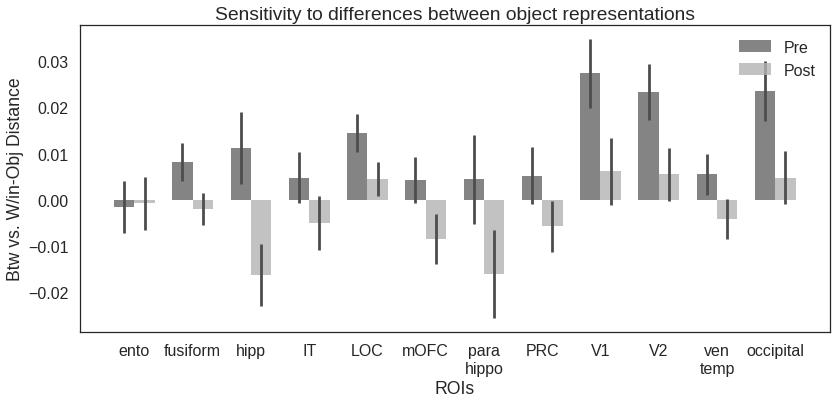

Saving figure to 'plots/object_discriminability_by_roi_group_mean.pdf'...
Done


In [86]:
ROIs = ["ento", "fusiform", "hipp", "IT", "LOC", "mOFC", "parahippo", "PRC", "V1", "V2", "ventemp", "occipital"]
ROIs_formatted = ["ento", "fusiform", "hipp", "IT", "LOC", "mOFC", "para\nhippo", "PRC", "V1", "V2", "ven\ntemp", "occipital"]

sns.set_style('white')
sns.set_context('poster')

means_pre = Diffpre.mean(1)
std_pre = Diffpre.std(1)/np.sqrt(shape(Diffpre)[1])

means_post = Diffpost.mean(1)
std_post = Diffpost.std(1)/np.sqrt(shape(Diffpost)[1])

fig, ax = plt.subplots(figsize=(len(ROIs),6))

n_groups = len(ROIs) # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.4,0.4,0.4)
rects1 = plt.bar(index, means_pre, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_pre,
                 error_kw=error_config,
                 label='Pre')

ccolor = (0.7,0.7,0.7)
rects2 = plt.bar(index + bar_width, means_post, bar_width,
                 alpha=opacity,
                 color=(0.7,0.7,0.7),
                 yerr=std_post,
                 error_kw=error_config,
                 label='Post')


plt.xlabel('ROIs')
plt.ylabel('Btw vs. W/in-Obj Distance')
plt.title('Sensitivity to differences between object representations')
plt.xticks(index + bar_width / 2, ROIs_formatted)
plt.legend()
plt.tight_layout()
plt.show()

save_out = 1
if save_out:
    helpers.save('plots/object_discriminability_by_roi_group_mean', ext='pdf', close=False, verbose=True)

### Learning-related changes in representational distance

In [87]:
Tradifflearn = Tradiffpost-Tradiffpre
Condifflearn = Condiffpost-Condiffpre

In [88]:
# ROIs = ['V1','fusiform','IT','LOC','occitemp']
print(Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1]))
print(Condifflearn.mean(1))

[ 0.01060281  0.00687597  0.01381946  0.0109816   0.00586362  0.01063006
  0.01351269  0.0094636   0.01752596  0.01396392  0.00770124  0.01394229]
[-0.00135155 -0.00681563 -0.02444984 -0.0128625  -0.00664787 -0.00543197
 -0.01850901 -0.01444141 -0.00943231 -0.00655239 -0.00850051 -0.00860216]


9


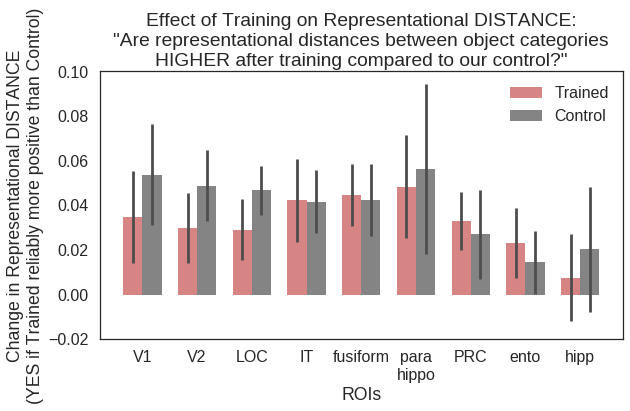

Saving figure to 'plots/differentiation_by_roi_group_mean.pdf'...
Done


In [38]:
## Generate summary plot (main analysis)

ROIs = ["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp"]
ROIs_formatted = ["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp"]

plot_indiv_subs = 0

sns.set_style('white')
sns.set_context('poster')
means_trained = Trained.mean(1)#Tradifflearn.mean(1)
std_trained = Trained.std(1)/np.sqrt(shape(Trained)[1]) #Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1])

means_control = Control.mean(1) #Condifflearn.mean(1)
std_control = Control.std(1)/np.sqrt(shape(Control)[1]) #Condifflearn.std(1)/np.sqrt(shape(Condifflearn)[1])


fig, ax = plt.subplots(figsize=(len(ROIs),6))

n_groups = len(ROIs) # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

print(len(means_trained))
## plot means as bars
tcolor = (0.8,0.4,0.4)
rects1 = plt.bar(index, means_trained, bar_width,
                 alpha=opacity,
                 color=(0.8,0.4,0.4),
                 yerr=std_trained,
                 error_kw=error_config,
                 label='Trained')

ccolor = (0.4,0.4,0.4)
rects2 = plt.bar(index + bar_width, means_control, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_control,
                 error_kw=error_config,
                 label='Control')

if plot_indiv_subs:
    ## now plot individual subjects as dots
    def generate_concat_tiled(array,reps):        
        inds = []
        for i in index:
            inds.append(np.tile(i,reps))
        return np.reshape(np.array(inds),(1,reps*len(array)))

    tindex = generate_concat_tiled(index,len(Tradifflearn[0]))
    tsubdists = np.reshape(Tradifflearn,(1,shape(Tradifflearn)[0]*shape(Tradifflearn)[1]))
    plt.scatter(tindex,tsubdists,s=25,alpha=0.2,color=tcolor)

    cindex = generate_concat_tiled(index,len(Condifflearn[0]))+bar_width
    csubdists = np.reshape(Condifflearn,(1,shape(Condifflearn)[0]*shape(Condifflearn)[1]))
    plt.scatter(cindex,csubdists,s=25,alpha=0.2,color=ccolor)

plt.xlabel('ROIs')
plt.ylabel('Change in Representational DISTANCE\n(YES if Trained reliably more positive than Control)')
plt.title('Effect of Training on Representational DISTANCE:\n"Are representational distances between object categories\nHIGHER after training compared to our control?"')
plt.xticks(index + bar_width / 2, ROIs_formatted)
plt.legend()
plt.tight_layout()
plt.ylim((-.02, .1))
plt.show()

save_out = 1
if save_out:
    if plot_indiv_subs:
        helpers.save('plots/differentiation_by_roi_indiv_sub', ext='pdf', close=False, verbose=True)
    else:
        helpers.save('plots/differentiation_by_roi_group_mean', ext='pdf', close=False, verbose=True)



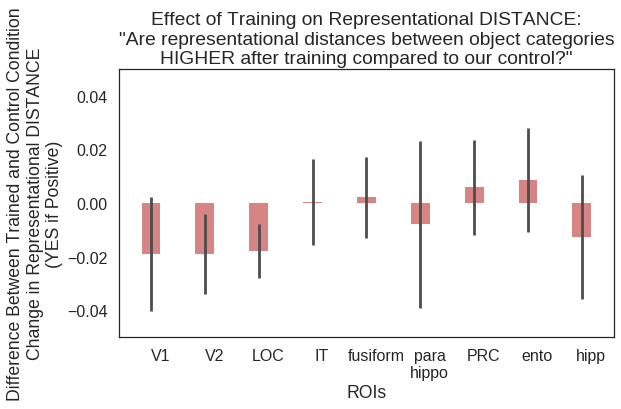

In [44]:
## Generate summary plot (main analysis)
plot_indiv_subs = 0

sns.set_style('white')
sns.set_context('poster')
means_trained = Trained.mean(1)#Tradifflearn.mean(1)
std_trained = Trained.std(1)/np.sqrt(shape(Trained)[1]) #Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1])

means_control = Control.mean(1) #Condifflearn.mean(1)
std_control = Control.std(1)/np.sqrt(shape(Control)[1]) #Condifflearn.std(1)/np.sqrt(shape(Condifflearn)[1])

diffdiff = Trained - Control #Tradifflearn-Condifflearn

fig, ax = plt.subplots(figsize=(len(ROIs),6))

n_groups = len(ROIs) # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.8,0.4,0.4)
rects1 = plt.bar(index, means_trained-means_control, bar_width,
                 alpha=opacity,
                 color=(0.8,0.4,0.4),
                 yerr=diffdiff.std(1)/np.sqrt(shape(diffdiff)[1]),
                 error_kw=error_config,
                 label='Trained')

ccolor = (0.4,0.4,0.4)
#rects2 = plt.bar(index + bar_width, means_control, bar_width,
#                 alpha=opacity,
##                 color=(0.4,0.4,0.4),
#                 yerr=std_control,
#                 error_kw=error_config,
#                 label='Control')

if plot_indiv_subs:
    ## now plot individual subjects as dots
    def generate_concat_tiled(array,reps):        
        inds = []
        for i in index:
            inds.append(np.tile(i,reps))
        return np.reshape(np.array(inds),(1,reps*len(array)))

    tindex = generate_concat_tiled(index,len(Tradifflearn[0]))
    tsubdists = np.reshape(Tradifflearn,(1,shape(Tradifflearn)[0]*shape(Tradifflearn)[1]))
    plt.scatter(tindex,tsubdists,s=25,alpha=0.2,color=tcolor)

    cindex = generate_concat_tiled(index,len(Condifflearn[0]))+bar_width
    csubdists = np.reshape(Condifflearn,(1,shape(Condifflearn)[0]*shape(Condifflearn)[1]))
    plt.scatter(cindex,csubdists,s=25,alpha=0.2,color=ccolor)

plt.xlabel('ROIs')
plt.title('Effect of Training on Representational DISTANCE:\n"Are representational distances between object categories\nHIGHER after training compared to our control?"')
plt.ylabel('Difference Between Trained and Control Condition\nChange in Representational DISTANCE\n(YES if Positive)')
plt.xticks(index + bar_width / 2,  ROIs_formatted)
#plt.legend()
plt.ylim((-.05, .05))

save_out = 0
if save_out:
    if plot_indiv_subs:
        helpers.save('plots/differentiation_by_roi_indiv_sub', ext='pdf', close=False, verbose=True)
    else:
        helpers.save('plots/differentiation_by_roi_group_mean', ext='pdf', close=False, verbose=True)

plt.tight_layout()
plt.show()

In [35]:
###### Variant of analysis ***ignoring training condition***, and just looking at overall change in between vs. within 
###### object similarity.

run_this = 0
if run_this:
    Witpre = []
    Btwpre = []
    Witpost = []
    Btwpost = []
    Diffpre = []
    Diffpost = []

    ROIs = ['V1','fusiform','paraphippo','IT','LOC','occitemp']

    for roi in ROIs:
        print(roi)
        _Witpre = []
        _Btwpre = []
        _Witpost = []
        _Btwpost = []
        _Diffpre = []
        _Diffpost = []
        for s in sub_dirs:
            wit_pre,btw_pre = compare_btw_wit_obj_similarity_across_runs(s,'pre',roi)
            wit_post,btw_post = compare_btw_wit_obj_similarity_across_runs(s,'post',roi)
            _Diffpre.append(btw_pre-wit_pre)
            _Diffpost.append(btw_post-wit_post)    
            _Witpre.append(wit_pre)
            _Btwpre.append(btw_pre)
            _Witpost.append(wit_post)
            _Btwpost.append(btw_post)    

        _Witpre,_Btwpre,_Witpost,_Btwpost,_Diffpre,_Diffpost = map(np.array,[_Witpre,_Btwpre,_Witpost,_Btwpost,_Diffpre,_Diffpost])

        if len(Witpre)==0:
            Witpre = _Witpre
            Btwpre = _Btwpre
            Witpost = _Witpost
            Btwpost = _Btwpost
            Diffpre = _Diffpre
            Diffpost = _Diffpost
        else:
            Witpre = np.vstack((Witpre,_Witpre))
            Btwpre = np.vstack((Btwpre,_Btwpre))   
            Witpost = np.vstack((Witpost,_Witpost))
            Btwpost = np.vstack((Btwpost,_Btwpost)) 
            Diffpre = np.vstack((Diffpre,_Diffpre))
            Diffpost = np.vstack((Diffpost,_Diffpost))         